In [1]:
from plugins.environments.awa_environment import AWAEnvironment
from plugins.interfaces.awa_interface import AWAInterface

# import data from csv file
import pandas as pd
variable_file = "plugins/environments/awa_variables.csv"
observable_file = "plugins/environments/awa_observables.csv"

env = AWAEnvironment(variable_file, observable_file, interface=AWAInterface(), target_charge=1.0)

In [2]:
env.variables

{'AWA:Drive:DS1:Ctrl': [500.0, 550.0],
 'AWA:Drive:DS3:Ctrl': [180.0, 260.0],
 'AWA:Bira3Ctrl:Ch03': [-5.0, 5.0],
 'AWA:Bira3Ctrl:Ch04': [-5.0, 5.0],
 'AWA:Bira3Ctrl:Ch05': [-5.0, 5.0],
 'AWA:Bira3Ctrl:Ch06': [-5.0, 5.0],
 'AWALLRF:K1:SetPhase': [236.0, 256.0],
 'AWA:DAC0:Ch08': [4.5, 5.9]}

In [3]:
from xopt import Xopt, Evaluator, VOCS
from xopt.generators.bayesian import BayesianExplorationGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.turbo import SafetyTurboController

import time

def evaluate(inputs):
    env.set_variables(inputs)
    time.sleep(2.0)
    result = env.get_observables(["13ARV1:Sx"])
    result["total_rms_size"] = (result["13ARV1:Sx"]**2 + result["13ARV1:Sy"]**2)**0.5
    return result

# use only one variable
vocs = VOCS(variables=env.variables,
            objectives={"total_rms_size":"MINIMIZE"},
            constraints={"13ARV1:penalty":["LESS_THAN",0.0]})


In [4]:

model_constructor = StandardModelConstructor(use_low_noise_prior=False)
generator = BayesianExplorationGenerator(
    vocs=vocs, 
    model_constructor=model_constructor,
    turbo_controller=OptimizeTurboController(vocs=vocs, length=0.1)
)
evaluator = Evaluator(function=evaluate)
X = Xopt(vocs=vocs, evaluator=evaluator, generator=generator)
X.options.dump_file = "optimization_1.yml"

In [5]:
X


            Xopt
________________________________
Version: 1.4.1+50.ge9fc8ac.dirty
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: exploration_1.yml, max_evaluations: null}
generator:
  name: bayesian_exploration
  model: null
  turbo_controller:
    dim: 8
    batch_size: 1
    length: 0.1
    length_min: 0.0078125
    length_max: 2.0
    failure_counter: 0
    failure_tolerance: 4
    success_counter: 0
    success_tolerance: 4
    center_x: null
    scale_factor: 1.25
    tkwargs: {dtype: torch.float64}
  use_cuda: false
  model_constructor:
    name: standard
    use_low_noise_prior: false
    covar_modules: {}
    mean_modules: {}
    trainable_mean_keys: []
    dtype: torch.float64
    device: cpu
  numerical_optimizer: {name: LBFGS, n_raw_samples: 20, n_restarts: 20, max_iter: 2000}
  max_travel_distances: null
  n_monte_carlo_samples: 128
evaluator:
  function: __main__.evaluate
  max_workers: 1
  function_kwargs: {}
  vectorized: false
vocs:
  var

In [6]:
# get the current quad setpoint
#current_val = env.get_variables(['AWA:Bira3Ctrl:Ch03'])
import numpy as np
default_pt = np.array([0, 0, 0, 0,5.9,550,190,246])
default_val = dict(zip(X.vocs.variable_names, default_pt))
default_val = pd.DataFrame(default_val, index=[0])
default_val

,AWA:Bira3Ctrl:Ch03,AWA:Bira3Ctrl:Ch04,AWA:Bira3Ctrl:Ch05,AWA:Bira3Ctrl:Ch06,AWA:DAC0:Ch08,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,AWALLRF:K1:SetPhase
0,0.0,0.0,0.0,0.0,5.9,550.0,190.0,246.0


In [7]:
# evaluate that point in xopt
X.evaluate_data(default_val)

"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Jun 15 2023 13:25:20.649190347
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArraySize1_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Jun 15 2023 13:25:20.649099576
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArrayData", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064Channel: "13ARV1:image1:ArraySize1_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Jun 15 2023 13:25:20.649283592
..................................................................
errlog: 4 messages were discarded
CA.Client.Exception.........................

,AWA:Bira3Ctrl:Ch03,AWA:Bira3Ctrl:Ch04,AWA:Bira3Ctrl:Ch05,AWA:Bira3Ctrl:Ch06,AWA:DAC0:Ch08,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,AWALLRF:K1:SetPhase,13ARV1:image1:ArraySize1_RBV,AWAVXI11ICT:Ch1,...,13ARV1:image1:ArraySize1_RBV_std,AWAVXI11ICT:Ch1_std,13ARV1:image1:ArraySize0_RBV_std,13ARV1:Cx_std,13ARV1:Cy_std,13ARV1:Sx_std,13ARV1:Sy_std,13ARV1:penalty_std,xopt_runtime,xopt_error
1,0.0,0.0,0.0,0.0,5.9,550.0,190.0,246.0,1200.0,9.836608e-10,...,0.0,4.544848e-11,0.0,0.862996,1.02617,2.103994,1.024185,5.255729,6.342549,False


In [8]:
# evaluate a second nearby point
second_pt = np.array([0.1, 0.1, 0.1, 0.1, 5.8,540,185,245])
second_pt = dict(zip(X.vocs.variable_names, second_pt))
second_pt = pd.DataFrame(second_pt, index=[0])
X.evaluate_data(second_pt)

,AWA:Bira3Ctrl:Ch03,AWA:Bira3Ctrl:Ch04,AWA:Bira3Ctrl:Ch05,AWA:Bira3Ctrl:Ch06,AWA:DAC0:Ch08,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,AWALLRF:K1:SetPhase,13ARV1:image1:ArraySize1_RBV,AWAVXI11ICT:Ch1,...,13ARV1:image1:ArraySize1_RBV_std,AWAVXI11ICT:Ch1_std,13ARV1:image1:ArraySize0_RBV_std,13ARV1:Cx_std,13ARV1:Cy_std,13ARV1:Sx_std,13ARV1:Sy_std,13ARV1:penalty_std,xopt_runtime,xopt_error
2,0.1,0.1,0.1,0.1,5.8,540.0,185.0,245.0,1200.0,1.017629e-09,...,0.0,5.081619e-11,0.0,2.261913,0.326947,4.029648,0.202594,7.496036,6.431805,False


In [9]:
X.data.keys()

Index(['AWA:Bira3Ctrl:Ch03', 'AWA:Bira3Ctrl:Ch04', 'AWA:Bira3Ctrl:Ch05',
       'AWA:Bira3Ctrl:Ch06', 'AWA:DAC0:Ch08', 'AWA:Drive:DS1:Ctrl',
       'AWA:Drive:DS3:Ctrl', 'AWALLRF:K1:SetPhase',
       '13ARV1:image1:ArraySize1_RBV', 'AWAVXI11ICT:Ch1',
       '13ARV1:image1:ArraySize0_RBV', '13ARV1:Cx', '13ARV1:Cy', '13ARV1:Sx',
       '13ARV1:Sy', '13ARV1:penalty', '13ARV1:image1:ArraySize1_RBV_std',
       'AWAVXI11ICT:Ch1_std', '13ARV1:image1:ArraySize0_RBV_std',
       '13ARV1:Cx_std', '13ARV1:Cy_std', '13ARV1:Sx_std', '13ARV1:Sy_std',
       '13ARV1:penalty_std', 'xopt_runtime', 'xopt_error'],
      dtype='object')

In [28]:
# run exploration
n_steps = 200
X.generator.numerical_optimizer.max_iter = 50
for i in range(n_steps):
    print(i)
    start = time.time()
    X.step()
    print(time.time() - start)
    

0
12.445687055587769
1
12.614635467529297
2
12.571729898452759
3
14.345133304595947
4
11.466700553894043
5
10.492931842803955
6
15.222670555114746
7
12.14604115486145
8


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


12.632185220718384
9
12.052273750305176
10
12.192116498947144
11
12.012635231018066
12
12.326795816421509
13


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


12.966497898101807
14
12.56470274925232
15
13.00773811340332
16
11.225881099700928
17
11.722891330718994
18


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


12.709970712661743
19


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


13.325978994369507
20
16.224519729614258
21
10.70099425315857
22
9.874598026275635
23


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


14.463383197784424
24
12.503758907318115
25
12.614653825759888
26


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


11.958400011062622
27
13.05301022529602
28
10.971025705337524
29
13.29536509513855
30
13.672807455062866
31


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


17.499555110931396
32
12.852354288101196
33
12.155897378921509
34
10.559866428375244
35
12.98311996459961
36
16.577028274536133
37
14.530991077423096
38
7.543283700942993
39
13.693339586257935
40
14.179988384246826
41
11.782172918319702
42
13.23877239227295
43


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


20.778517961502075
44


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


10.746435165405273
45


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


14.226466178894043
46
8.970497369766235
47
14.076699256896973
48
12.276093006134033
49
10.253344297409058
50


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


15.80734395980835
51


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


12.148027896881104
52


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


14.04686975479126
53


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


12.230133771896362
54


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


9.690404653549194
55
12.077274560928345
56
11.8562490940094
57
14.397340536117554
58
13.112398147583008
59


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


10.908089637756348
60
12.876532554626465
61


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


10.22727084159851
62
14.905163764953613
63


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


12.496502161026001
64
15.492899417877197
65
9.82007360458374
66


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


13.750982761383057
67
13.612548351287842
68


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


14.183696508407593
69


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:390: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


7.478365421295166
70
12.662977933883667
71


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


10.850293397903442
72
14.709516286849976
73


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


16.464414834976196
74


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


12.086141347885132
75


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


13.455066204071045
76


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


11.476319551467896
77


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


11.018347263336182
78
14.002233505249023
79


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:390: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


8.795341968536377
80


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:390: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


9.68450379371643
81
16.760658502578735
82


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


12.84419059753418
83


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


11.464361429214478
84
17.027183294296265
85


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


16.137341022491455
86


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


12.874215602874756
87
13.187576293945312
88


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


15.28006362915039
89
14.46137285232544
90
14.496036052703857
91
14.064768552780151
92


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


20.705108642578125
93


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


12.240494728088379
94
10.833813905715942
95


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


13.778546333312988
96


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


16.180959939956665
97
13.712949514389038
98
15.787979364395142
99
11.931260108947754
100
8.067435264587402
101
15.253840446472168
102
14.00465703010559
103
14.669238328933716
104
11.3396897315979
105
11.451462984085083
106
15.064434289932251
107
17.099793910980225
108
14.093873739242554
109
13.818110704421997
110
19.76408290863037
111


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


17.055037260055542
112
15.49497938156128
113


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


15.35220718383789
114


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


10.629119873046875
115
15.536847591400146
116
12.326315641403198
117
21.938384294509888
118
8.148028373718262
119
10.338051319122314
120


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


15.06294584274292
121
14.253386974334717
122
12.712860345840454
123
15.492459535598755
124
7.957232236862183
125
13.828127145767212
126


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


14.740015745162964
127
14.28836441040039
128


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


15.279188871383667
129


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


13.464140892028809
130
12.503472089767456
131
16.302961587905884
132
13.025719404220581
133
9.457464456558228
134
11.996477842330933
135
18.412277221679688
136


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


10.182422399520874
137
14.804126024246216
138


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


16.418293476104736
139


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


24.19616460800171
140
11.735328912734985
141
11.97956895828247
142
13.286802768707275
143
12.72365427017212
144
13.277039289474487
145
14.25443983078003
146


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


13.498260974884033
147
11.894853830337524
148
22.606611728668213
149


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


30.044844150543213
150
11.499190092086792
151
12.997406005859375
152
10.055546283721924
153
12.313267707824707
154
14.646442651748657
155


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


19.201069355010986
156
15.105392456054688
157
11.712294816970825
158
13.513080596923828
159
16.82944655418396
160


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


15.691356658935547
161
15.28789734840393
162
19.219245195388794
163
18.077377319335938
164


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


18.44352412223816
165


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


15.215134620666504
166


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


16.443071365356445
167
17.375827074050903
168
19.013044834136963
169


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


14.04918622970581
170
12.50531005859375
171
19.744564294815063
172
15.996386051177979
173


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


18.497716188430786
174
17.547143936157227
175
20.769007682800293
176
11.9834566116333
177
12.00841212272644
178
16.99316716194153
179
13.110754251480103
180
12.425037622451782
181
13.706391334533691
182
14.879828453063965
183
14.939302682876587
184


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:390: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


12.279103517532349
185
11.244606256484985
186


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:390: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


8.279902696609497
187
14.006498098373413
188
13.480807065963745
189


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


13.930267572402954
190
17.095357656478882
191


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


12.732075214385986
192


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


12.548951387405396
193
17.4811372756958
194
12.497928380966187
195


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/botorch/optim/optimize.py:366: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


11.591213941574097
196
14.958382368087769
197


/home/awa/awa-badger/plugins/environments/awa_environment.py:269: RuntimeWarning: invalid value encountered in scalar divide
  Cx = m10 / m00
/home/awa/awa-badger/plugins/environments/awa_environment.py:270: RuntimeWarning: invalid value encountered in scalar divide
  Cy = m01 / m00


14.731589794158936
198
13.493936777114868
199
12.755314350128174


In [29]:
X.data

,AWA:Bira3Ctrl:Ch03,AWA:Bira3Ctrl:Ch04,AWA:Bira3Ctrl:Ch05,AWA:Bira3Ctrl:Ch06,AWA:DAC0:Ch08,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,AWALLRF:K1:SetPhase,13ARV1:image1:ArraySize1_RBV,AWAVXI11ICT:Ch1,...,13ARV1:Cx_std,13ARV1:Cy_std,13ARV1:Sx_std,13ARV1:Sy_std,13ARV1:penalty_std,xopt_runtime,xopt_error,grad,int_grad,sx_m
1,0.000000,0.000000,0.000000,0.000000,5.900000,550.000000,190.000000,246.000000,1200.0,9.836608e-10,...,0.862996,1.026170,2.103994,1.024185,5.255729e+00,6.342549,False,0.000000,0.000000,0.002073
2,0.100000,0.100000,0.100000,0.100000,5.800000,540.000000,185.000000,245.000000,1200.0,1.017629e-09,...,2.261913,0.326947,4.029648,0.202594,7.496036e+00,6.431805,False,0.089300,0.107160,0.004247
3,0.554108,0.554108,-0.454108,0.554108,5.779836,547.391843,183.484956,246.505424,1200.0,1.031181e-09,...,NaN,NaN,NaN,NaN,6.355287e-14,6.926599,False,0.494818,0.593782,NaN
4,-0.454108,0.554108,0.554108,-0.454108,5.900000,543.578181,191.515044,244.494576,1200.0,1.025616e-09,...,1.241388,0.575224,1.877709,0.235569,3.932545e+00,5.899030,False,0.494818,0.593782,0.002808
5,-0.634028,-0.304150,-0.304150,-0.634028,5.799608,543.772161,192.747269,244.106779,1200.0,9.781675e-10,...,NaN,NaN,NaN,NaN,6.355287e-14,5.897739,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,0.961148,-3.473108,4.617575,-1.649020,4.560838,502.989245,226.712713,252.904178,1200.0,9.377265e-10,...,0.482180,1.779636,0.092763,0.245129,1.982193e+00,5.928160,False,NaN,NaN,NaN
224,2.621665,-2.206433,2.961309,-1.894091,5.047365,500.333185,224.505731,249.203681,1200.0,9.463246e-10,...,2.596290,3.943310,1.206970,0.609666,5.788575e+00,7.046226,False,NaN,NaN,NaN
225,-0.842684,-2.178655,3.422653,-2.826529,5.639730,530.633540,180.641563,239.299616,1200.0,9.732056e-10,...,NaN,NaN,NaN,NaN,6.355287e-14,7.375389,False,NaN,NaN,NaN
226,-1.232438,-0.402926,4.047199,-3.559788,4.807675,520.510684,242.345318,252.755239,1200.0,9.793861e-10,...,2.538849,0.676201,0.393933,0.096650,2.511243e+00,7.377628,False,NaN,NaN,NaN


<Axes: >

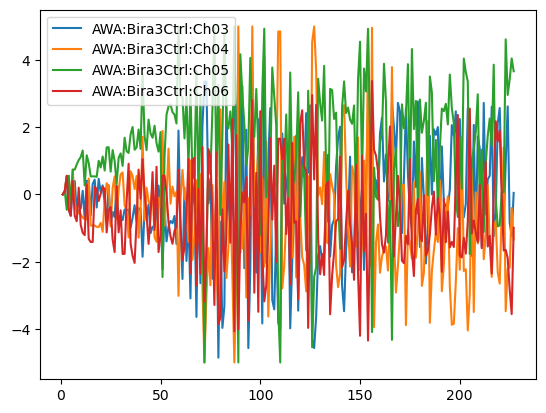

In [30]:
X.data.plot(y=X.vocs.variable_names[:4])

<Axes: >

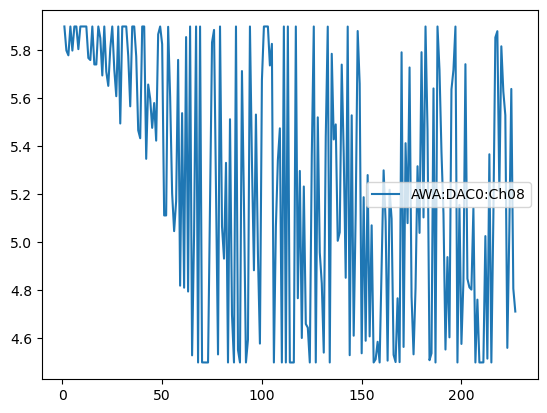

In [32]:
X.data.plot(y=X.vocs.variable_names[4])

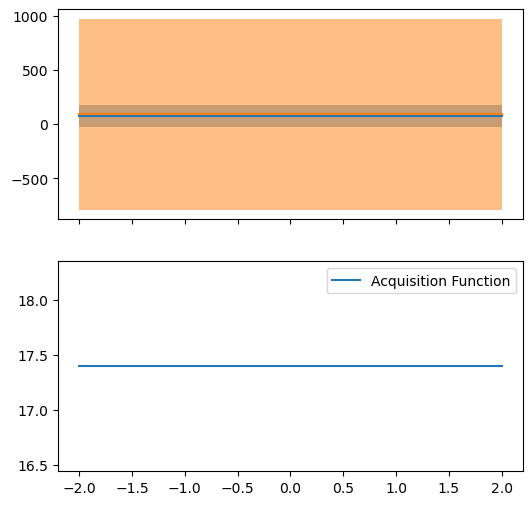

In [14]:
import torch
import matplotlib.pyplot as plt
test_x = torch.linspace(-2,2, 100)
model = X.generator.train_model()

fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1).double())
    for i in range(post.event_shape[-1]):
        mean = post.mean[...,i].squeeze()
        l,u = post.mvn.confidence_region()
        ax[0].plot(test_x, mean,f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l[...,i].squeeze(), u[...,i].squeeze(), alpha=0.5)


    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    ax[1].plot(test_x, acq, label='Acquisition Function')
    ax[1].legend()

In [15]:
from emitopt.utils import get_valid_emittance_samples
beam_energy = 45*10**-3 # GeV 
q_len = 0.12 # m
distance = 1.33-0.265 #m

data = X.data

data["grad"] = data["AWA:Bira3Ctrl:Ch04"] * 100*8.93e-3
data["int_grad"] = data["grad"]*q_len*10

data["sx_m"] = 3.9232781168265036e-05 * data["13ARV1:Sx"]

data


,AWA:Bira3Ctrl:Ch03,AWA:Bira3Ctrl:Ch04,AWA:Bira3Ctrl:Ch05,AWA:Bira3Ctrl:Ch06,AWA:DAC0:Ch08,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,AWALLRF:K1:SetPhase,13ARV1:image1:ArraySize1_RBV,AWAVXI11ICT:Ch1,...,13ARV1:Cx_std,13ARV1:Cy_std,13ARV1:Sx_std,13ARV1:Sy_std,13ARV1:penalty_std,xopt_runtime,xopt_error,grad,int_grad,sx_m
1,0.000000,0.000000,0.000000,0.000000,5.900000,550.000000,190.000000,246.000000,1200.0,9.836608e-10,...,0.862996,1.026170,2.103994,1.024185,5.255729e+00,6.342549,False,0.000000,0.000000,0.002073
2,0.100000,0.100000,0.100000,0.100000,5.800000,540.000000,185.000000,245.000000,1200.0,1.017629e-09,...,2.261913,0.326947,4.029648,0.202594,7.496036e+00,6.431805,False,0.089300,0.107160,0.004247
3,0.554108,0.554108,-0.454108,0.554108,5.779836,547.391843,183.484956,246.505424,1200.0,1.031181e-09,...,NaN,NaN,NaN,NaN,6.355287e-14,6.926599,False,0.494818,0.593782,NaN
4,-0.454108,0.554108,0.554108,-0.454108,5.900000,543.578181,191.515044,244.494576,1200.0,1.025616e-09,...,1.241388,0.575224,1.877709,0.235569,3.932545e+00,5.899030,False,0.494818,0.593782,0.002808


torch.Size([3, 1])
torch.Size([3, 1])


/home/awa/miniconda3/envs/awa-badger/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


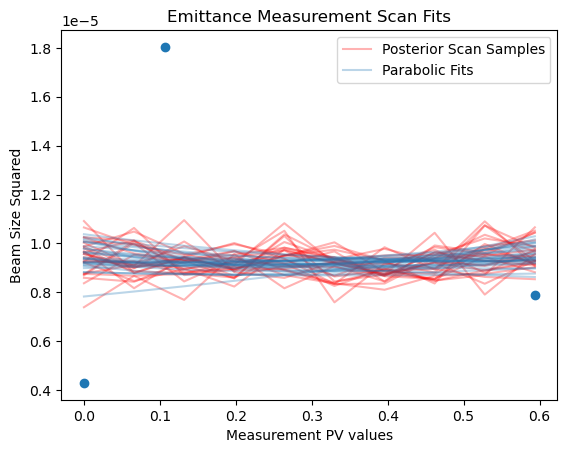

In [16]:
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch import ExactMarginalLogLikelihood

from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll

train_x = torch.tensor(data.dropna()["int_grad"].to_numpy()).double().unsqueeze(1)
train_y = torch.tensor(data.dropna()["sx_m"].to_numpy()).double().unsqueeze(1)

print(train_x.shape)
print(train_y.shape)
input_transform = Normalize(1)
outcome_transform = Standardize(1)
covar_module = ScaleKernel(PolynomialKernel(power=2))
#covar_module = MaternKernel()

model = SingleTaskGP(train_x, 
                     train_y, 
                     input_transform=input_transform,
                     outcome_transform=outcome_transform, 
                     covar_module = covar_module
                     )

mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)


(emits_at_target_valid,
 emits_sq_at_target,
 is_valid,
 sample_validity_rate) = get_valid_emittance_samples(model, beam_energy,
                                                     q_len,
                                                     distance, n_samples=50, n_steps_quad_scan=10, visualize=True)

Text(0, 0.5, 'Probability Density')

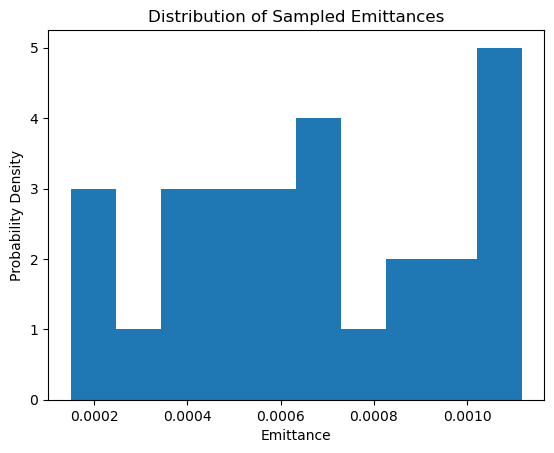

In [17]:
plt.hist(emits_at_target_valid.flatten()*90)
plt.title('Distribution of Sampled Emittances')
plt.xlabel('Emittance')
plt.ylabel('Probability Density')